# Introduction
Extra code to obtain mu and stochastic volatility parameters for SNP500

In [8]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

import datetime
import yfinance as yf

import numpy as np
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

# Cox-Ross

In [9]:
from dataclasses import dataclass
from typing import Optional, NoReturn

@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        if 2 * self.a * self.b < self.c ** 2:
            raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [10]:
def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

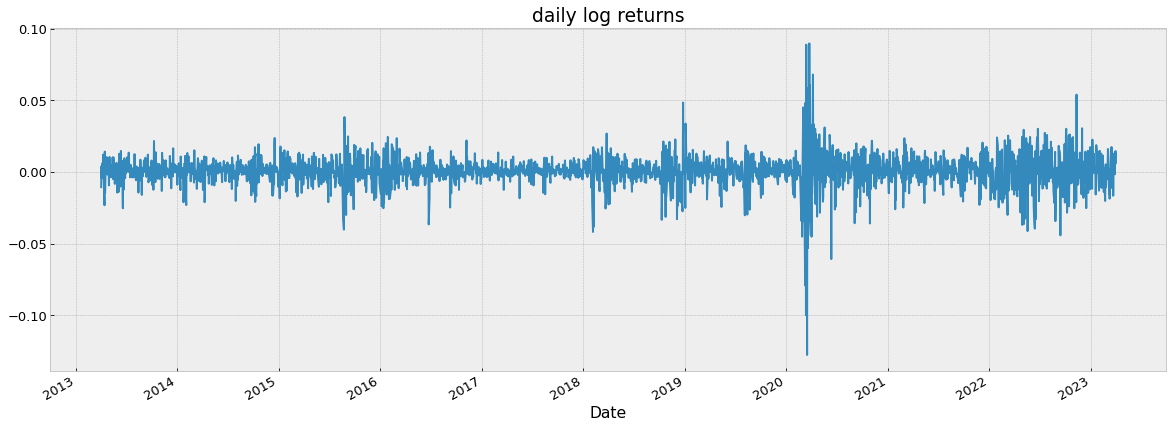

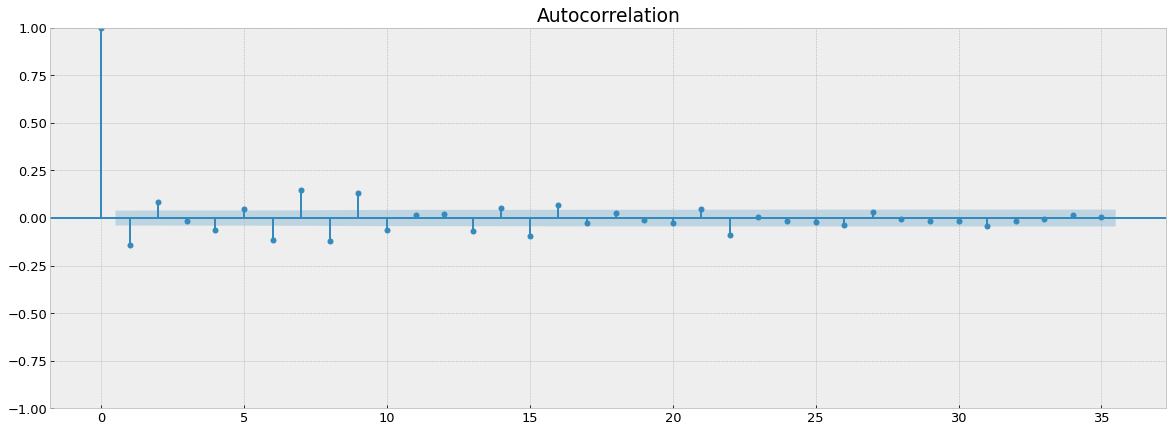

In [11]:
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=365*10)

stock_prices = yf.Ticker("^GSPC").history(start=startDate, end=endDate)
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()


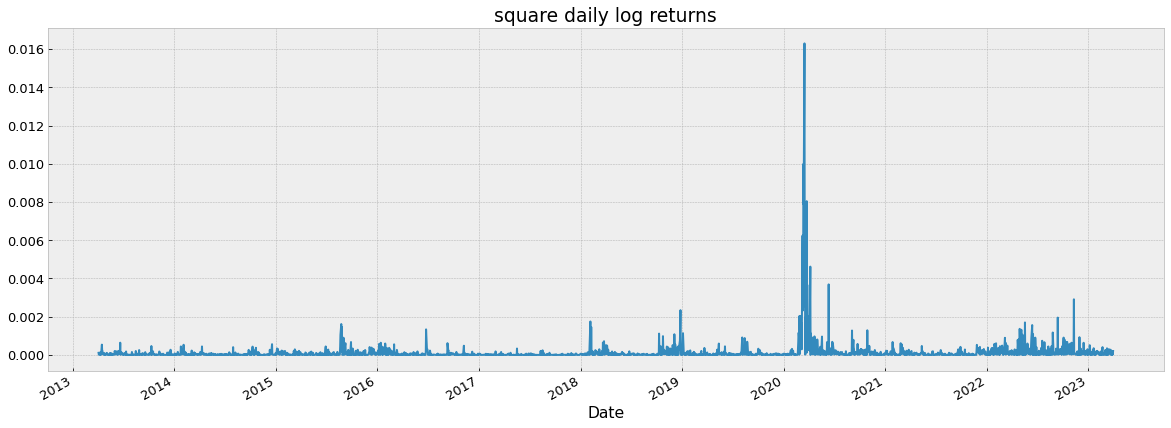

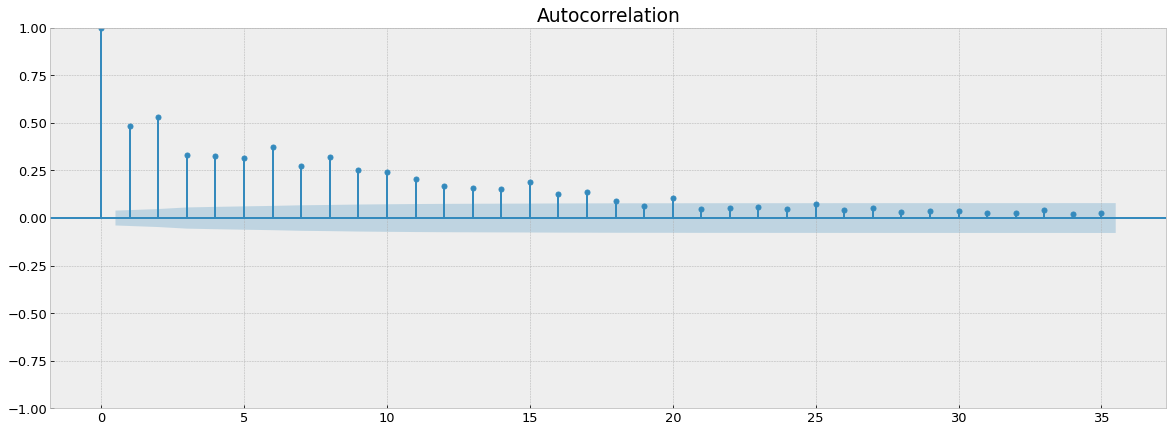

In [12]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

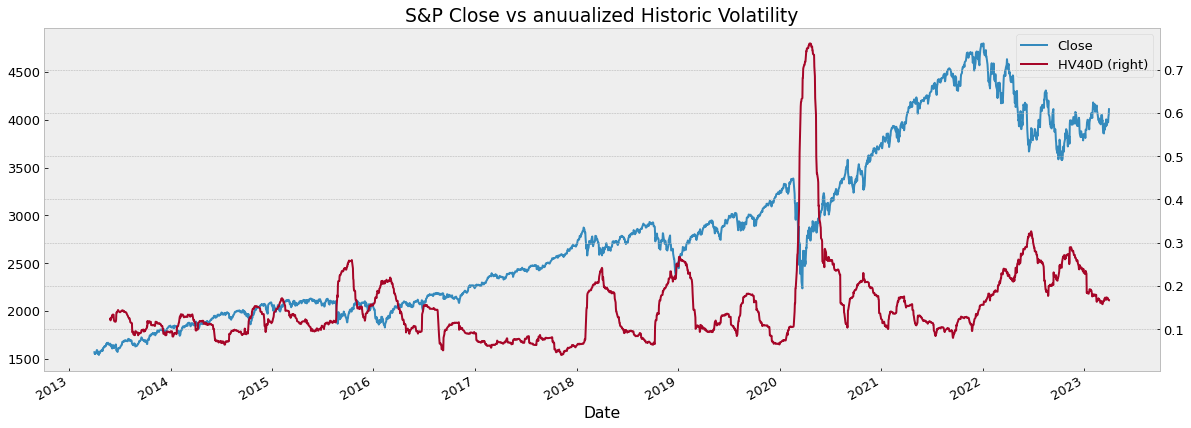

mu          = 0.09620
vol_(t=0)   = 0.16679


In [13]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna() ; volatility.name = "HV40D"
stock_prices.Close.plot(title='S&P Close vs anuualized Historic Volatility', legend=True)
volatility.plot(secondary_y=True, legend=True)
plt.show()

mu = np.log(stock_prices.Close[-1]/stock_prices.Close[0])/10
print(f'mu          = {mu:.5f}')
print(f'vol_(t=0)   = {volatility[-1]:.5f}')

In [14]:
# estimate parameters
CIR_params_hat = estimate_CIR_params(volatility.values)
CIR_params_hat

CIRParams(a=0.0033281299103885727, b=0.1562947229160206, c=0.01583113545983743)

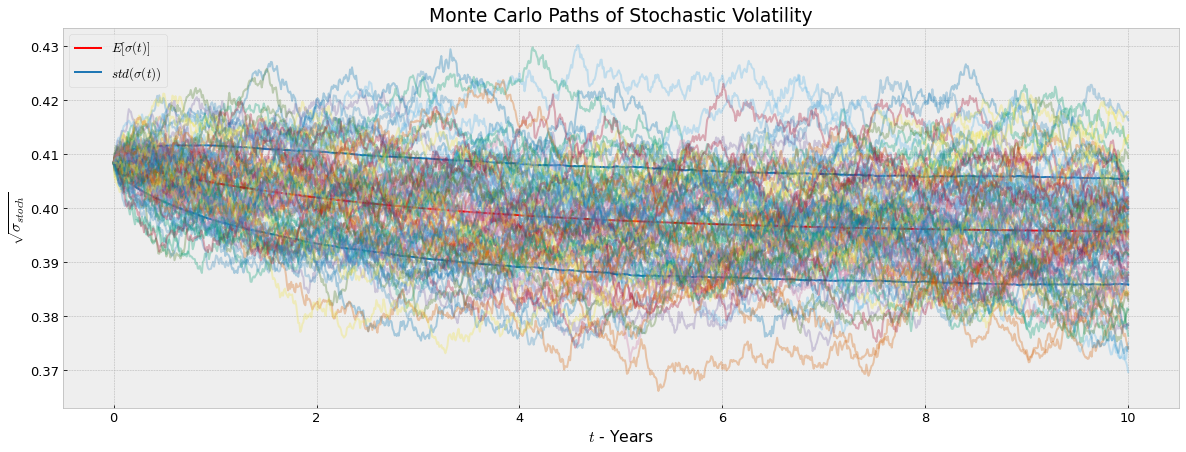

In [9]:
import scipy.stats as stats
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

s0 = 0.16679
a=0.0033281299103885727
b=0.1562947229160206
c=0.01583113545983743

T = 10
n_paths = 10
n_time_steps = 1001
dt = 1/100

def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

W_SV    = sobol_norm(n_paths, d=n_time_steps, seed=1234)

""" SV - Verion """
vt = np.full(shape=(int(2**n_paths),n_time_steps), fill_value=s0) # initial variance 
for t in range(1,1001):
    """ Advanced Version : continious time + Stochastic Volatility """
    # Simulate variance processes
    vt[:,t] = vt[:,t-1] + a*(b - vt[:,t-1]) + c*np.sqrt(vt[:,t-1]*dt)*W_SV[:,t]

fig, ax = plt.subplots()
ax.plot(np.linspace(0,T, n_time_steps), np.sqrt(vt).mean(axis=0), c='r')
ax.plot(np.linspace(0,T, n_time_steps), np.sqrt(vt).std(axis=0) + np.sqrt(vt).mean(axis=0), c='tab:blue')
ax.plot(np.linspace(0,T, n_time_steps), -np.sqrt(vt).std(axis=0) + np.sqrt(vt).mean(axis=0), c='tab:blue')
ax.legend([r'$E[\sigma(t)]$', '$std(\sigma(t))$'])
pd.DataFrame(np.sqrt(vt).T, index=(np.linspace(0,T, n_time_steps)))\
    .sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$\sqrt{\sigma_{stoch}}$', \
        xlabel=r'$t$ - Years', title='Monte Carlo Paths of Stochastic Volatility', ax=ax) 
plt.show()